# Demo RNA Multi-Perceptrón Backpropagation aplicando funciones de Lógica Difusa para la preparación de los datos  para clasificar (atributo clase discreto) o estimar (atributo clase continuo)

In [ ]:
#@title Librerías a usar
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import os
import csv

print("Librerías cargadas")

Librerías cargadas


In [ ]:
#@title Acceder al Drive

# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = '/content/gdrive/My Drive/IA/demoML/datos/'  #@param {type:"string"}


Mounted at /content/gdrive


In [ ]:
#@title Cargar datos

## selección de los parámetros 

def cargarNombreClases(path, archivo_datos, atributo_clase, nombre_clases):
  # importa definición de la clase
  arClasesFN = archivo_datos.split('.')[0] + '_nombreClases.txt'
  if os.path.isfile( path + '/' + arClasesFN ):
    with open( path + '/' + arClasesFN, mode='r') as csvfile:
        r = csv.reader(csvfile, delimiter=',')
        auxAtributo = r.__next__()
        auxClases = r.__next__()
    print('\n> Definición de los valores discretos para la clase cargada de ' + arClasesFN +'.\n')
    return auxAtributo[0], ','.join(auxClases)
  else:
    return atributo_clase, nombre_clases

#@markdown ### Archivo de datos a utilizar:
archivo_datos = 'IRIS.csv'  #@param {type:"string"}
#@markdown ### Nombre del atributo clase / objetivo:
atributo_clase = '-' #@param {type:"string"}
#@markdown ### Descripción de los valores del atributo clase / objetivo:  (nota: siempre debe comienzar en 0, por lo que si no tiene valor 0, agregar "na")
nombre_clases = '-' #@param {type:"string"}

## aplicación de los parámetros elegidos

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + archivo_datos)
print("Archivo de datos ", archivo_datos, " cargado")

print("\n> Cabecera: ")
print(df.head())
print("\n> Características: ")
print(df.describe())


# intenta cargar configuración asociada a los datos
if atributo_clase == '' or  atributo_clase == '-':
  # trata de obtener la configuración del archivo asociado
  atributo_clase, nombre_clases = cargarNombreClases(path, archivo_datos, atributo_clase, nombre_clases)

# define nombre atributo de CLASE para ejemplo IRIS
ClassAttributeName = atributo_clase

print("\n> Atributo clase ", ClassAttributeName, ": [", nombre_clases, "]")

# genera los datos solo con la clase para entrenar y probar
Y = np.array(df.pop(ClassAttributeName))
X = np.array(df)


Archivo de datos  IRIS.csv  cargado

> Cabecera: 
   LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo  Clase
0          5.1          3.5          1.4          0.2      1
1          4.9          3.0          1.4          0.2      1
2          4.7          3.2          1.3          0.2      1
3          4.6          3.1          1.5          0.2      1
4          5.0          3.6          1.4          0.2      1

> Características: 
       LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo       Clase
count   150.000000   150.000000   150.000000   150.000000  150.000000
mean      5.843333     3.054000     3.758667     1.198667    2.000000
std       0.828066     0.433594     1.764420     0.763161    0.819232
min       4.300000     2.000000     1.000000     0.100000    1.000000
25%       5.100000     2.800000     1.600000     0.300000    1.000000
50%       5.800000     3.000000     4.350000     1.300000    2.000000
75%       6.400000     3.300000     5.100000     1.800000    3.000000
max

In [ ]:
#@title Configuración de las Funciones Difusas 

# Indica parámetros para Funciones de Pertenencia de Lógica Difusa 
# para IRIS usando valores determinados por FISPro para funciones Trapezoidales
# (se indica con el mismo orden que los atributos,
#  los vectores para los intervalos correspondientes)

configMFs = {
    #  atributo #0: LargoSepalo  
    0: 
     [  #[a, b, c, d]
         [0.0, 4.3, 5.0, 6.0], # MF1
         [5.0, 5.5, 6.5, 7.0], # MF2
         [6.0, 7.0, 8.0, 8.0]  # MF3
    ],
    #  atributo #1: AnchoSepalo  
    1:  
     [  #[a, b, c, d]
         [0.0, 2.0, 2.5, 3.0], # MF1
         [2.5, 3.0, 3.0, 3.5], # MF2
         [3.0, 3.5, 3.5, 4.0], # MF3
         [3.5, 4.0, 5.0, 5.0]  # MF4
    ],   
    #  atributo #2: LargoPetalo    
    2:  
     [  #[a, b, c, d]
         [0.0, 1.0, 1.5, 4.0], # MF1
         [1.5, 2.0, 3.0, 4.5], # MF2
         [4.0, 4.5, 5.5, 6.0], # MF3
         [5.5, 6.0, 8.0, 8.0]  # MF4
    ],
    #  atributo #3: AnchoPetalo         
    3:  
     [  #[a, b, c, d]
         [0.0, 0.1, 0.5, 1.1], # MF1
         [0.1, 1.0, 1.0, 2.1], # MF2
         [1.5, 2.1, 3.0, 3.0]  # MF3
    ],    
}

In [ ]:
#@title Aplicar Lógica Difusa
# aplica las fórmulas obtenidas de 
# http://www.dma.fi.upm.es/recursos/aplicaciones/logica_borrosa/web/tutorial_fuzzy/contenido3.html    


# aplica función Trapezoidal 
# usando los valores [a, b, c, d] por cada MF
def aplicaFuncionTrapezoide(val, paramMF):
  cantMF = len(paramMF)
  # si no está definido, devuelve directamente el valor
  if cantMF == 0:
    return [val]
  auxRes = []
  for i in range(cantMF):    
    
    if i == 0:
      # trapezoide inferior
      if val > paramMF[i][3]:
        # mayor que 'd'
        auxRes.append( 0.0 )
      elif val < paramMF[i][2]:
        # menor que 'c'
        auxRes.append( 1.0 )
      else:
        # entre 'c' y 'd'
        auxRes.append( (paramMF[i][3]-val)/(paramMF[i][3]-paramMF[i][2]) )

    elif i == (cantMF-1):
      # trapezoide superior
      if val < paramMF[i][0]:
        # menor que 'a'
        auxRes.append( 0.0 )
      elif val > paramMF[i][1]:
        # mayor que 'b'
        auxRes.append( 1.0 )
      else:
        # entre 'a' y 'b'
        auxRes.append( (val-paramMF[i][0])/(paramMF[i][1]-paramMF[i][0]) )

    else:
      # trapezoide medio
      if val < paramMF[i][0]:
        # menor que 'a'
        auxRes.append( 0.0 )
      elif val > paramMF[i][3]:
        # mayor que 'd'
        auxRes.append( 0.0 )
      elif (val >= paramMF[i][0]) and (val <= paramMF[i][1]):
        # entre 'a' y' b'
        auxRes.append( (val-paramMF[i][0])/(paramMF[i][1]-paramMF[i][0]) )
      elif (val >= paramMF[i][2]) and (val <= paramMF[i][3]):
        # entre 'c' y 'd'
        auxRes.append( (paramMF[i][3]-val)/(paramMF[i][3]-paramMF[i][2]) )
      else:
        # entre 'b' y 'c'
        auxRes.append( 1.0 )

  return auxRes

# función auxiliar para asignar los MF según los valores de la lista de valores
def fuzzificar(datos, configMFs):   
  # si no hay valores para devolver
  if len(datos)==0:
    return []
  # inicializa lista para devolver los valores
  auxRes = []
  # recorre las filas de los datos 
  # y asigna los valores correspondientes 
  # a los atributos
  for fila in datos:
    auxResFila = []
    for i in range(len(fila)):
      if i in configMFs:
        # si está definida, la configuración calcula los MFs
        auxResFila.extend( aplicaFuncionTrapezoide(fila[i], configMFs[i]) )
      else:
        # si no está definida, agrega el valor original
        auxResFila.append( fila[i] )
    auxRes.append( auxResFila)
  return np.array(auxRes)


print("10 primeros datos de Entrada antes de fuzzificar: ")
print(X[:10])

X = fuzzificar(X, configMFs)

print("\n\n10 primeros datos de Entrada después de fuzzificar: ")
print(X[:10])

10 primeros datos de Entrada antes de fuzzificar: 
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]]


10 primeros datos de Entrada después de fuzzificar: 
[[0.9        0.2        0.         0.         0.         1.
  0.         1.         0.         0.         0.         1.
  0.11111111 0.        ]
 [1.         0.         0.         0.         1.         0.
  0.         1.         0.         0.         0.         1.
  0.11111111 0.        ]
 [1.         0.         0.         0.         0.6        0.4
  0.         1.         0.         0.         0.         1.
  0.11111111 0.        ]
 [1.         0.         0.         0.         0.8        0.2
  0.         1.         0.         0.         0.         1.
  0.11111111 0.        ]
 [1.         0.         0.         0.         0.         0.8
  0.2        1.         0.         0.         0.         1.


In [ ]:
#@title Preparar datos 

#@markdown Determina si el atributo clase debe ser considerado como Discreto o Continuo
considerar_atributo_clase = "dicreto - CLASIFICACION" #@param ["dicreto - CLASIFICACION", "continuo - ESTIMACION"] 

#@markdown Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento =   75#@param {type:"integer"}

# determina la proporción a usar para entrenar y probar
if proporcion_porcentaje_datos_entrenamiento>100:
  propTrain = 1
elif proporcion_porcentaje_datos_entrenamiento<1:
  propTrain = 0.1
else:
  propTrain = proporcion_porcentaje_datos_entrenamiento/100

# determina si es problema de clasificación o estimación
esProblemaClasificacion = (considerar_atributo_clase[0].upper() == "D")

# separa al azar usando muestreo con proporción indicada
if esProblemaClasificacion:
  # intenta hacer muestreo estatificado 
  try:
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), stratify=Y)
  except ValueError:
    print("-- No se puede aplicar Muestreo Estratificado! -> se usa Muestreo Simple \n")
    # hace muestreo simple
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain))
else:
  # hace muestreo simple
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain))

CLASES = []
if esProblemaClasificacion:
  print("> se considera problema de CLASIFICACIÓN \n")

  # define nombre de clases     
  if (nombre_clases == "") or (nombre_clases == "-"):
      # toma los valores de clase orginales del archivo
      for val in range(np.max(Y)+1):
        CLASES.append( "clase {:>3}".format(val) )
  else:
      # toma configuración de nombre de clases
      for val in nombre_clases.split(','):
        CLASES.append( val )

  # genera salida codificada para softMax
  y_trainEnc =  np_utils.to_categorical(y_train)
  y_testEnc =  np_utils.to_categorical(y_test)

  # muestra resultados
  print("> Definición de CLASES: ")
  print(" - dictMapeo (", len(CLASES), "): ", CLASES)
else:
  print("> se considera problema de ESTIMACIÓN \n")

  y_trainEnc = []
  y_testEnc =  []


print("\n> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_train (cant): ", len(y_train))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    cant = 0
    for y in y_train:
      if i == y: cant = cant + 1
    print("    ", CLASES[i], "[", i, "]:", cant)

print("\n Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_test (cant): ", len(y_test))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    cant = 0
    for y in y_test:
      if i == y: cant = cant + 1
    print("    ", CLASES[i], "[", i, "]:", cant)


> se considera problema de CLASIFICACIÓN 

> Definición de CLASES: 
 - dictMapeo ( 4 ):  ['na', 'Setosa', 'Versicolor', 'Virginica']

> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (112, 14)
 - y_train (cant):  112
     na [ 0 ]: 0
     Setosa [ 1 ]: 37
     Versicolor [ 2 ]: 37
     Virginica [ 3 ]: 38

 Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (38, 14)
 - y_test (cant):  38
     na [ 0 ]: 0
     Setosa [ 1 ]: 13
     Versicolor [ 2 ]: 13
     Virginica [ 3 ]: 12


Modelo creado con  7  capas:
Model: "RNA"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 14)]              0         
                                                                 
 bn_1 (BatchNormalization)   (None, 14)                56        
                                                                 
 hidd_2 (Dense)              (None, 240)               3600      
                                                                 
 hidd_3 (Dense)              (None, 60)                14460     
                                                                 
 d_4 (Dropout)               (None, 60)                0         
                                                                 
 hidd_5 (Dense)              (None, 12)                732       
                                                                 
 output (Dense)              (None

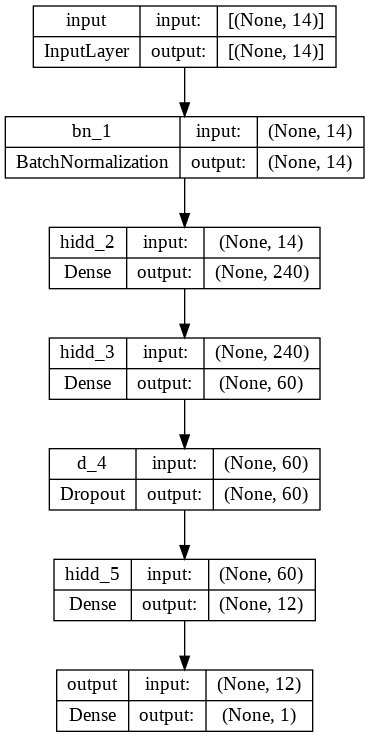

In [ ]:
#@title Establecer modelo

#@markdown ### Parámetros de la Red:
rna_cant_neuronas_capas_ocultas = 'BN, 240, 60, D, 12' #@param {type:"string"}
#@markdown (Nota: se puede indicar Cantidad de neuronas, D para DropOut, BN para BatchNormalization)
lineal_porc_capa_DropOut = 0.5 #@param {type:"number"}

rna_tipo_capa_salida = 'lineal-Numero' #@param ["lineal-Numero", "softmax-MultiClase"]

#@markdown ### Parámetros del Optimizador:
opt_tipo = "Adam" #@param ["Gradiente Decreciente", "Adam", "Adadelta", "Adagrad", "Adamax", "Nadam", "FTRL"]
opt_learning_rate = 0.05 #@param {type: "number"}

## aplicación de los parámetros elegidos

# define tamaño de datos de entrada 
num_inputs = x_train.shape[1]

# cantidad de neuronas ocultas 
#hidden_layers = [ num_inputs*3//4, num_inputs//2 ] 
hidden_layers = []
for val in lineal_cant_neuronas_capas_ocultas.split(','):
  val = val.strip()
  if val == "D":
    hidden_layers.append( "DropOut" )  
  elif val == "BN":
    hidden_layers.append( "BatchNormalization" )  
  elif val.isnumeric():
    hidden_layers.append( val )
  else:
    print("Capa ", val, "descartada!")

# chequea configuración de drop out
if lineal_porc_capa_DropOut <= 0:
  lineal_porc_capa_DropOut = 0.10
elif lineal_porc_capa_DropOut > 0.9:
    lineal_porc_capa_DropOut = 0.9
  

# define si el tipo de capa de salida es softmax( True )  o lineal ( False )
# esto implica también cambiar cómo se codifican los valores de las clases a usar
if esProblemaClasificacion:
  tipo_output_softMax = (rna_tipo_capa_salida[:7] == 'softmax')
else:
  print("-- se considera salida lineal porque es problema de Estimación!")
  tipo_output_softMax = False


# define la arquitectura de capas teniendo en cuenta la definición dada anteriomente
input_Lay = tf.keras.layers.Input(shape=(num_inputs,), name='input') # capa de entrada
eachLay = input_Lay
auxName = 'hidd_'
auxId = 1 
for val_hid in hidden_layers:  

  if val_hid == "DropOut":
    auxlayerName = "d_"+str(auxId)
    auxId = auxId + 1
    eachLay = tf.keras.layers.Dropout(lineal_porc_capa_DropOut,name=auxlayerName)(eachLay)
  elif val_hid == "BatchNormalization":
    auxlayerName = "bn_"+str(auxId)
    auxId = auxId + 1
    eachLay = tf.keras.layers.BatchNormalization(name=auxlayerName)(eachLay)
  elif val_hid.isnumeric():
    # agrega la capa oculta
    auxlayerName = auxName+str(auxId)
    auxId = auxId + 1
    eachLay = tf.keras.layers.Dense(int(val_hid), name=auxlayerName)(eachLay) # capas ocultas

# agrega capa de salida
if esProblemaClasificacion and tipo_output_softMax:
    # se genera una capa softmax
    output_Lay = tf.keras.layers.Dense(units = len(CLASES), activation='softmax', name='output')(eachLay) # capa de salida
else:
    # se genera una capa lineal con una salida numérica
    output_Lay = tf.keras.layers.Dense(1, activation=None, name='output')(eachLay) # capa de salida

if opt_tipo == "Gradiente Decreciente":
  opt = keras.optimizers.SGD(learning_rate=opt_learning_rate)
elif opt_tipo == "Adam":
  opt = keras.optimizers.Adam(learning_rate=opt_learning_rate)
elif opt_tipo == "Adadelta":
  opt = keras.optimizers.Adadelta(learning_rate=opt_learning_rate)
elif opt_tipo == "Adagrad":
  opt = keras.optimizers.Adagrad(learning_rate=opt_learning_rate)
elif opt_tipo == "Adamax":
  opt = keras.optimizers.Adamax(learning_rate=opt_learning_rate)
elif opt_tipo == "Nadam":
  opt = keras.optimizers.Nadam(learning_rate=opt_learning_rate)
elif opt_tipo == "FTRL":
  opt = keras.optimizers.Ftrl(learning_rate=opt_learning_rate)
else:
  opt = keras.optimizers.Adam()

# genera el modelo RNA MLP Backpropagation
model = Model(input_Lay, output_Lay, name='RNA')
if tipo_output_softMax:
    # utiliza un loss de multiple clases
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
else:
    # utiliza un loss de valor numérico
    if esProblemaClasificacion:
      model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])
    else:
      model.compile(optimizer=opt, loss='mse', metrics=['RootMeanSquaredError'])

print("Modelo creado con ", len(model.layers), " capas:")
model.summary()
print("\n")
plot_model(model, show_layer_names=True, show_shapes=True)


In [ ]:
#@title Entrenar

cant_epocas_entrenamiento = 100 #@param {type:"integer"}

# cantidad de épocas del entrenamiento
cantEpocas = (1 if cant_epocas_entrenamiento<1 else cant_epocas_entrenamiento)

activar_corte_por_estabilidad_error_val = False #@param {type:"boolean"}

# separa al azar usando muestreo al azar del 10%
# para tomar algunos como datos de validación
x_t, x_v, y_t, y_v = train_test_split(x_train, 
                                       (y_trainEnc if tipo_output_softMax else y_train), 
                                       test_size=0.1)

print("\n> De los ", len(x_train), "ejemplos de entrenamiento: ")
print("            se usan ", len(x_t), "ejemplos para entrenar ")
print("            y ", len(x_v), "ejemplos para validar.")

print("\n\n>Comienza el Entrenamiento:")

if activar_corte_por_estabilidad_error_val:
  # se agrega un callBack para que corte 
  # si el error de validación no sigue bajando
  # y devuelva los mejores pesos obtenidos
  early_stopping_monitor = keras.callbacks.EarlyStopping(
      monitor='val_loss',
      min_delta=0.01,
      patience=20,
      verbose=0,
      mode='min',
      baseline=None,
      restore_best_weights=True
  )
  callbacksEntr = [early_stopping_monitor]
else:
  early_stopping_monitor = None
  callbacksEntr = []

# lleva a cabo el entrenamiento
history = model.fit(x_t, y_t,
          epochs = cantEpocas, 
          validation_data=(x_v, y_v,),
          callbacks=callbacksEntr ) 

print("\n>Entrenamiento Finalizado.")



> De los  112 ejemplos de entrenamiento: 
            se usan  100 ejemplos para entrenar 
            y  12 ejemplos para validar.


>Comienza el Entrenamiento:
Epoch 1/100
4/4 [==============================] - 1s 53ms/step - loss: 92.9087 - accuracy: 0.1400 - val_loss: 1.7592 - val_accuracy: 0.3333
Epoch 2/100
4/4 [==============================] - 0s 9ms/step - loss: 56.9825 - accuracy: 0.0900 - val_loss: 3.1301 - val_accuracy: 0.0833
Epoch 3/100
4/4 [==============================] - 0s 10ms/step - loss: 27.1647 - accuracy: 0.1700 - val_loss: 5.0746 - val_accuracy: 0.0000e+00
Epoch 4/100
4/4 [==============================] - 0s 11ms/step - loss: 13.4636 - accuracy: 0.1400 - val_loss: 0.9268 - val_accuracy: 0.3333
Epoch 5/100
4/4 [==============================] - 0s 10ms/step - loss: 8.7228 - accuracy: 0.3300 - val_loss: 2.9448 - val_accuracy: 0.3333
Epoch 6/100
4/4 [==============================] - 0s 9ms/step - loss: 3.6009 - accuracy: 0.2400 - val_loss: 1.5524 - val_accuracy

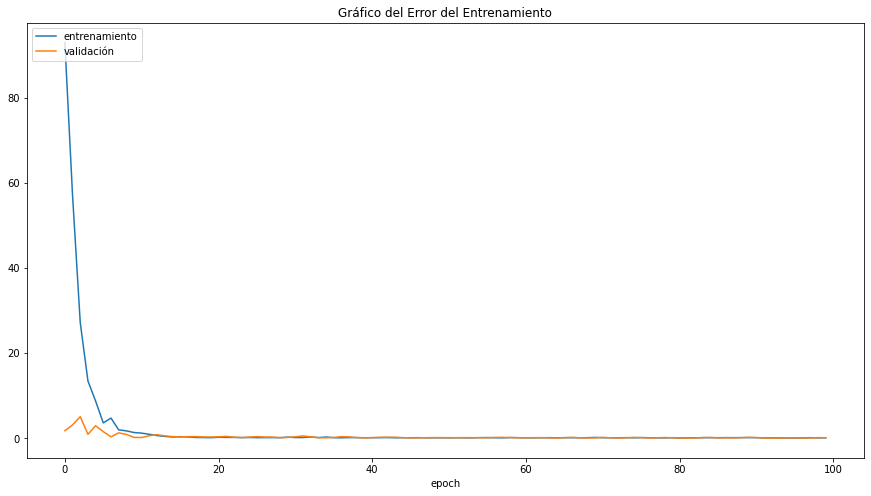

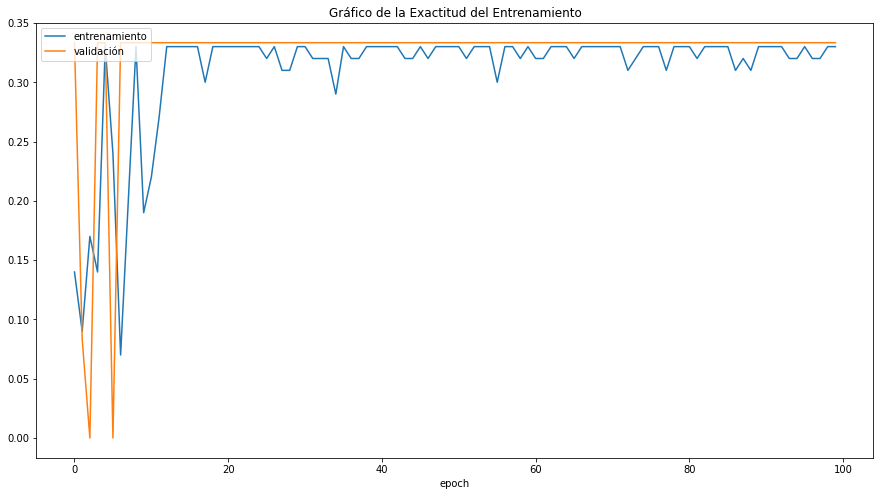

In [ ]:
#@title Mostrar Gráficos del Entrenamiento
plt.figure(figsize=(15,8)) 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Gráfico del Error del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

plt.figure(figsize=(15,8)) 
if esProblemaClasificacion:
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Gráfico de la Exactitud del Entrenamiento')
else:
  plt.plot(history.history['root_mean_squared_error'])
  plt.plot(history.history['val_root_mean_squared_error'])
  plt.title('Gráfico de la Distancia Media Cuadrática Mínima del Entrenamiento')
  
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

*** Resultados con datos de Entrenamiento: 

 Reporte de Clasificación: 
              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        37
  Versicolor       0.80      1.00      0.89        37
   Virginica       1.00      0.76      0.87        38

    accuracy                           0.92       112
   macro avg       0.93      0.92      0.92       112
weighted avg       0.94      0.92      0.92       112


Matriz de Confusión ( real / modelo ): 
              m:Setosa  m:Versicolor  m:Virginica  m:na
r:Setosa            37             0            0     0
r:Versicolor         0            37            0     0
r:Virginica          0             9           29     0
r:na                 0             0            0     0




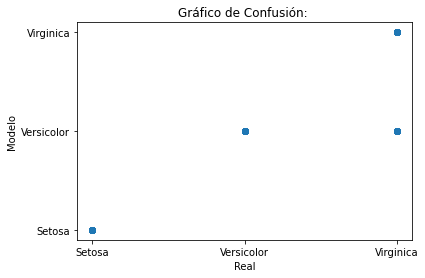

In [ ]:
#@title Probar red entrenada con datos de entrenamiento

mostrar_detalle_entrenamiento = False #@param {type:"boolean"}

# función auxiliar para el cálculo de error
def calcErrores(pred, real, mostrarDetalle=False):
  arAbs = []
  arRel = []
  
  if mostrarDetalle:
    print("\n")
    print("\t Real \t\t\t Estimado \t\t Error Absoluto \t Error Relativo")

  for pV, r in zip(pred, real):
    # toma el valor estimado/predecido
    p = pV[0]
    # controla que sean números
    if not(math.isnan(r) or math.isnan(p)):
      # hace los cálculos
      eAbs = abs(r - p)
      if r != 0:
        eRel = (eAbs / r)*100.0
      else:
        eRel = (eAbs / 0.00001)*100.0
      arAbs.append(eAbs)
      arRel.append(eRel)
    
      if mostrarDetalle:
        print("\t{:>8.2f} \t\t {:>8.2f} \t\t {:>8.2f} \t\t {:>8.2f}%".format(r, p, eAbs, eRel))

  return arAbs, arRel

def generarGrafico(ar, tit, b=10, c=None):
     # genera gráfico de los errores
    fig = plt.figure(figsize=(15,5)) 
 #   ax = fig.add_axes( [0, 0, 0.8, 0.8] )
 #   ax.boxplot( [arAbs, arRel] )
 #   ax.set_xticklabels( ["Error Absoluto", "Error Relativo"] )
#    plt.legend(["Error Absoluto", "Error Relativo"], loc='best')
    plt.hist( ar, bins=b, color=c )
    plt.grid(color='lightgrey', which='both', axis='both', linestyle='solid', linewidth=0.3)
    plt.title("Distribución de "+ tit)
    plt.show()


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo_Estimacion(x, y, detalle=False):

    # procesa las imágenes de prueba con el modelo 
    estimVals = model.predict(x, verbose=0)

    # llama a la función
    arAbs, arRel = calcErrores(estimVals, y, detalle)

    # muestra métricas
    print("\n")
    print("\n Error Absoluto: ")
    print("            Mínimo: {:.5f} ".format(np.min(arAbs)) )
    print("            Promedio: {:.5f} ± {:.5f}".format(np.mean(arAbs), np.std(arAbs)) )
    print("            Máximo: {:.5f} ".format(np.max(arAbs)) )
    generarGrafico(arAbs, "Error Absoluto", 20, "red")
    
    print("\n Error Relativo: ")
    print("            Mínimo: {:.2f}% ".format(np.min(arRel)) )
    print("            Promedio: {:.2f} ± {:.2f}".format(np.mean(arRel), np.std(arRel)) )
    print("            Máximo: {:.2f}% ".format(np.max(arRel)) )
    generarGrafico(arRel, "Error Relativo", 10, "magenta")


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo_Clasificacion(x, y, clases_map, mostrarDetalle=False):

    # procesa las imágenes de prueba con el modelo 
    predClass = model.predict(x, verbose=0)

    # muestra los resultados con las imágenes 
    umbralClas = 0.5
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # prepara salida
        clReal = clases_map[ y[i] ] 

        # determina la clase predecida
        if tipo_output_softMax:
            ## determina clase predecida de acuerdo a la que tiene mayor valor
            idclPred = int( np.argmax(predClass[i], axis=0) )
            idclPredRnd = idclPred
        else:
            ## determina clase predecida de acuerdo al umbral de clasificación
            idclPred = predClass[i][0]       
            idclPredRnd = int(idclPred)
            if (idclPred - idclPredRnd)>0.5 and (idclPredRnd+1)<len(clases_map):
                    idclPredRnd = idclPredRnd + 1

        if idclPredRnd<0 or idclPredRnd>=len(clases_map):
            clPred = "CLASE " + str(idclPredRnd) + " INVÁLIDA"
        else:      
            clPred = clases_map[ idclPredRnd ]

        classReal.append( clReal )
        classPreds.append( clPred )

        strTitulo = 'Real: ' + str(clReal) + ' / Modelo(RNA): ' 
        strTitulo = strTitulo + str(clPred) + ' (' + str( idclPred ) +')'   
        strTitulo = strTitulo + ": " + ("ok" if (clPred==clReal) else "error!")

        # muestra comparación con la imagen
        if mostrarDetalle:
          print(strTitulo)

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds))

    # muestra matriz de confusion
    print('\nMatriz de Confusión ( real / modelo ): ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_map)
    cmtx = pd.DataFrame(
        cm, 
        index=['r:{:}'.format(x) for x in clases_map], 
        columns=['m:{:}'.format(x) for x in clases_map]
      )
    # agrega para poder mostrar la matrix de confusión completa
    pd.options.display.max_rows = 100
    pd.options.display.max_columns = 100
    cmtx.sort_index(axis=0, inplace=True)
    cmtx.sort_index(axis=1, inplace=True)    
    print(cmtx)
    print("\n")

    # gráfico de comparación
    plt.title('Gráfico de Confusión: ')
    plt.xlabel('Real')
    plt.ylabel('Modelo')
    plt.scatter(classReal, classPreds)

# prueba con los datos de entrenamiento
print("*** Resultados con datos de Entrenamiento: ")
if esProblemaClasificacion:
  probarModelo_Clasificacion(x_train, y_train, CLASES, mostrar_detalle_entrenamiento)
else:
  probarModelo_Estimacion(x_train, y_train, mostrar_detalle_entrenamiento)



>Evaluación del Modelo: 
    - Error:  0.093
    - Exactitud:  34.21


*** Resultados con datos de Prueba: 

 Reporte de Clasificación: 
              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        13
  Versicolor       0.76      1.00      0.87        13
   Virginica       1.00      0.67      0.80        12

    accuracy                           0.89        38
   macro avg       0.92      0.89      0.89        38
weighted avg       0.92      0.89      0.89        38


Matriz de Confusión ( real / modelo ): 
              m:Setosa  m:Versicolor  m:Virginica  m:na
r:Setosa            13             0            0     0
r:Versicolor         0            13            0     0
r:Virginica          0             4            8     0
r:na                 0             0            0     0




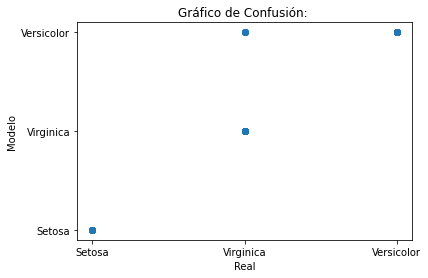

In [ ]:
#@title Probar red entrenada con datos de prueba
mostrar_detalle_prueba = False #@param {type:"boolean"}

  # evalua al modelo entrenado
resEval = model.evaluate(x_test, (y_testEnc if tipo_output_softMax else y_test), verbose=0)
print("\n>Evaluación del Modelo: ")
print("    - Error: ", round(resEval[0],3))
if esProblemaClasificacion:
  print("    - Exactitud: ", round(resEval[1]*100,2))
else:
  print("    - Distancia Media Cuadrática Mínima: ", round(resEval[1],3))
  
#print("\n")

# prueba con los datos de prueba
print("\n\n*** Resultados con datos de Prueba: ")
if esProblemaClasificacion:
  probarModelo_Clasificacion(x_test, y_test, CLASES, mostrar_detalle_prueba)
else:
  probarModelo_Estimacion(x_test, y_test, mostrar_detalle_prueba)


In [ ]:
#@title Inspeccionar influencia de los Atributos de Entrada 
determinar_influencia = False #@param {type:"boolean"}

# fuente: https://scikit-learn.org/stable/modules/permutation_importance.html

from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer

# define la función para calculo del error
# contando la cantidad de diferencias 
# entre clase real y predecida
def calc_error(realClasses, predClasses):
    res = 0
    for i in range(len(realClasses)):
      # determina la clase predecida
      if tipo_output_softMax:
          ## determina clase predecida de acuerdo a la que tiene mayor valor
          idclPred = int( np.argmax(predClasses[i], axis=0) )
          idclPredRnd = idclPred
          idReal = int( np.argmax(realClasses[i], axis=0) )
      else:
          ## determina clase predecida de acuerdo al umbral de clasificación
          idclPred = predClasses[i][0]       
          idclPredRnd = int(idclPred)
          if (idclPred - idclPredRnd)>0.5 and (idclPredRnd+1)<len(CLASES):
                  idclPredRnd = idclPredRnd + 1
          idReal = int(realClasses[i])
      res = res + abs(idReal-idclPredRnd)
    return res
errorScorer = make_scorer(calc_error, greater_is_better=False, )

def realizarInspeccion(tipoDatos, xScoring, yScoring):
  print("")
  # Genera el scoring usando permutaciones 
  # para realizar el cálculo del scoring
  scoring = {'R2 score':'r2', 
             'Error de Clase':errorScorer}
  r_multi  = permutation_importance(model, xScoring, yScoring,
                              n_repeats=30,
                              random_state=0,
                              scoring=scoring)

  # muesta las métricas
  print("> Cálculo de influencia con datos de " + tipoDatos + ":")
  for metric in r_multi:
    print("- Métrica "+metric+":")
    r = r_multi[metric]
    i = 0
    for imp in r.importances:
        print(f"\tAtributo {i:<2} [ {df.columns[i]} ]:  "
              f"{np.mean(imp):.3f} ± {np.std(imp):.3f}"
              f" [ {np.min(imp):.3f}; {np.max(imp):.3f} ]"
              )
        i = i + 1
  return

if determinar_influencia:
    # Ejecuta con ambos sets de datos
    realizarInspeccion(tipoDatos="Entrenamiento",  
                      xScoring = x_train,
                      yScoring = (y_trainEnc if tipo_output_softMax else y_train))

    realizarInspeccion(tipoDatos="Prueba",  
                      xScoring = x_test,
                      yScoring = (y_testEnc if tipo_output_softMax else y_test))

